##  train TFL net
In this part, we will train a model for predicting Traffic-light (**TFL**) in image patches,
we will use the data generated in previous part to this end. 

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np, matplotlib.pyplot as plt
from os.path import join

## Data validation
     we will use the example in the cell below, to verify the TFL patch we've generated is sane.

val :  (582, 81, 81, 3) 0/1 split 50.0 %
train :  (3316, 81, 81, 3) 0/1 split 50.0 %


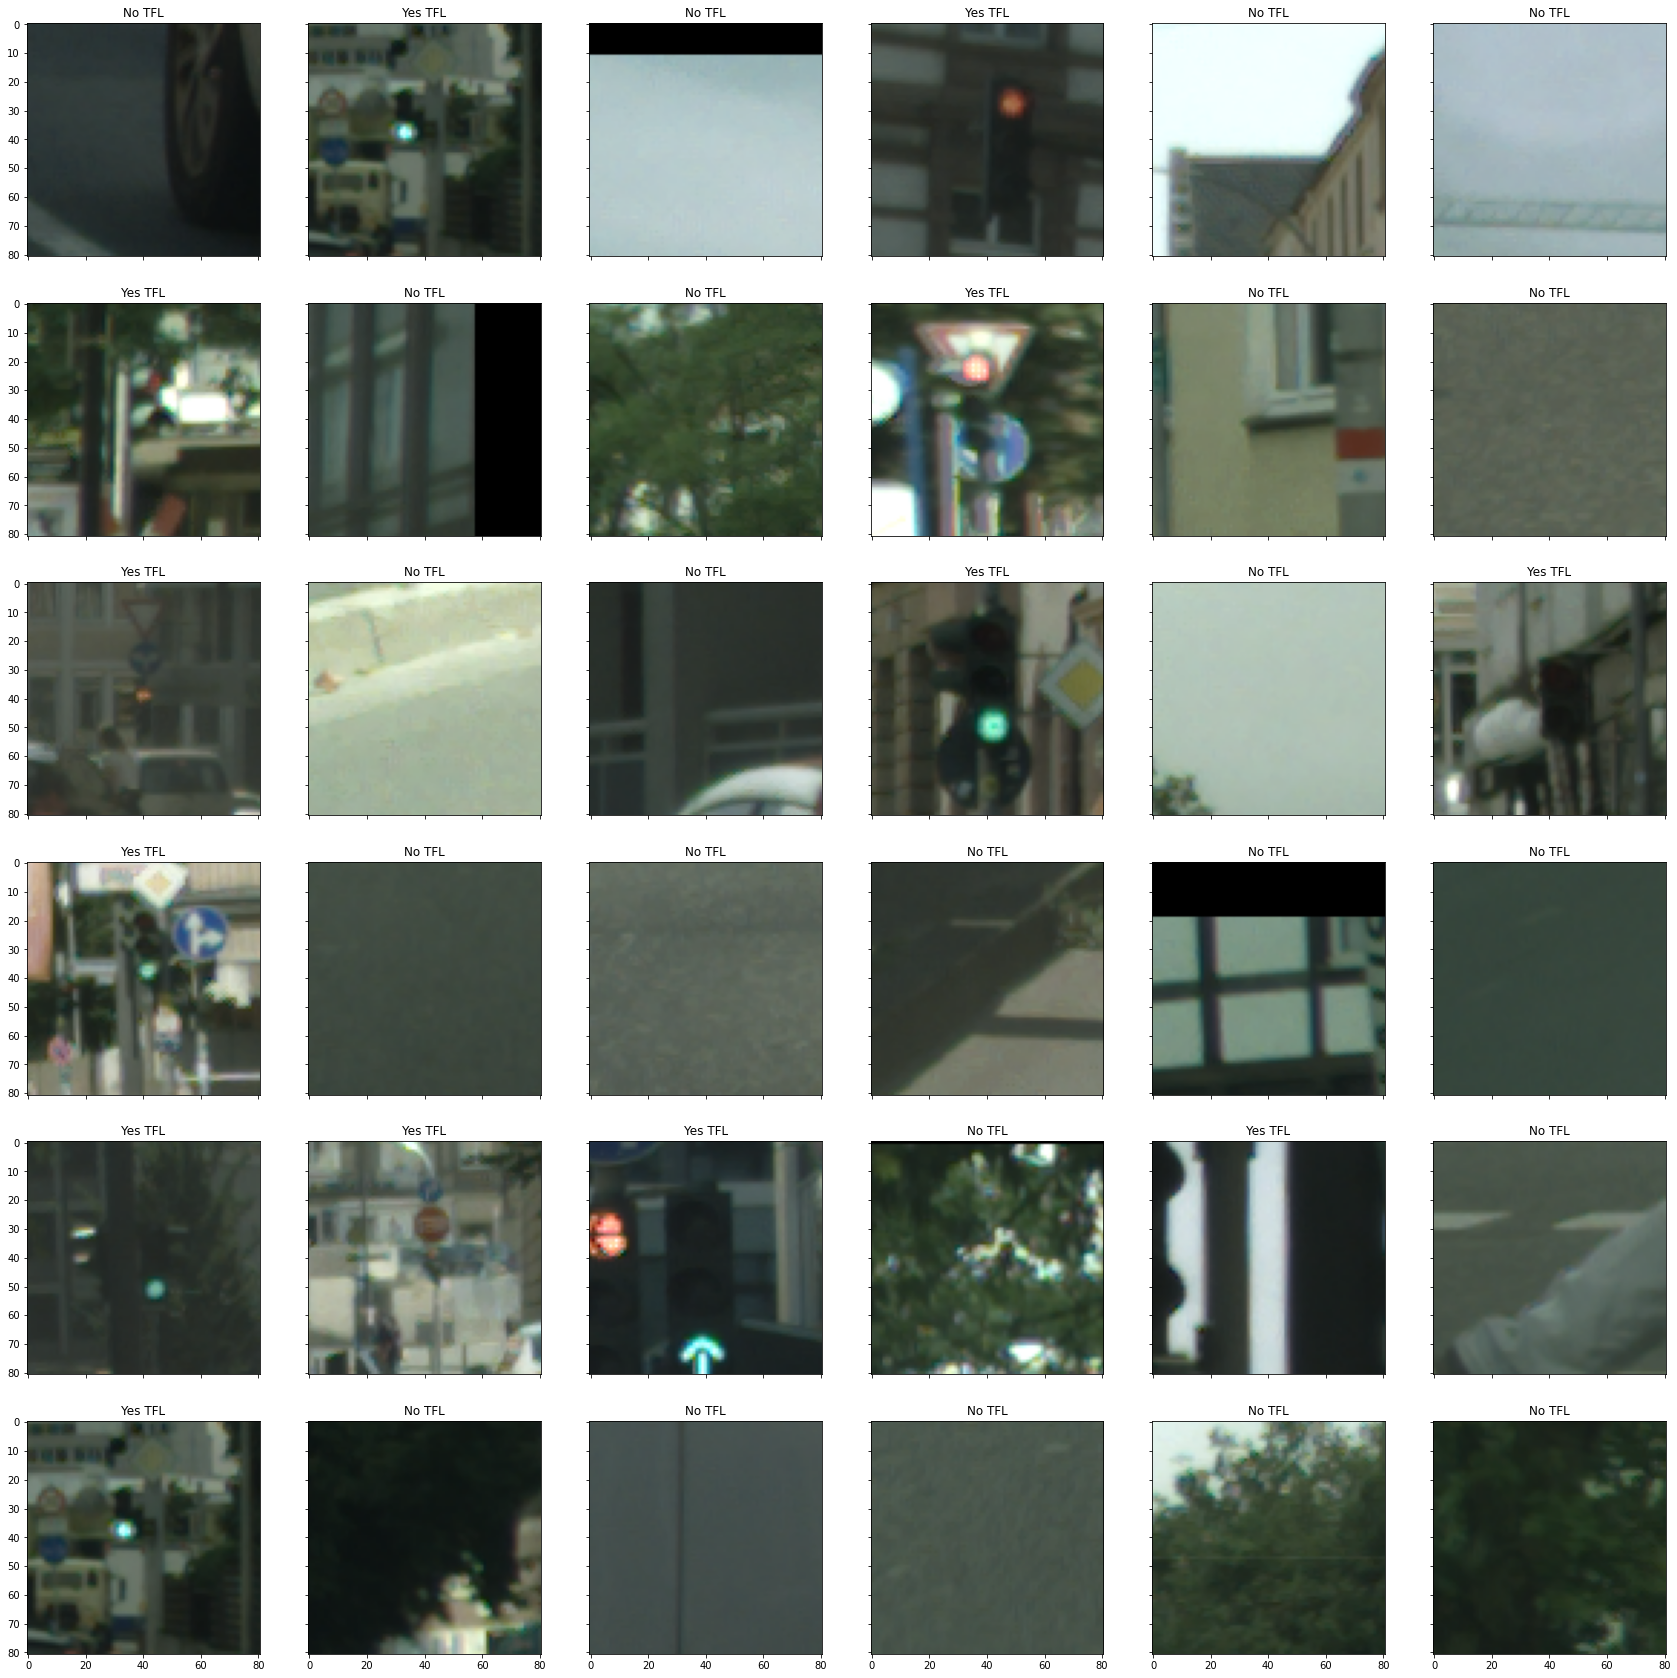

In [2]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h= 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {}'.format(labels2name[predictions[idx]])
        ax.flatten()[i].set_title(title)
    

root = './data_train'  #this is the root for your val and train datasets
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

## definition the model used for training


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, MaxPooling2D, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 79, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 79, 79, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 77, 77, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 32)        9

## train

In [13]:
from keras.losses import sparse_categorical_crossentropy
root = './data_train'
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
#prepare our model
m = tfl_model()
m.compile(optimizer=keras.optimizers.Adam(), loss =sparse_categorical_crossentropy, metrics=['accuracy'])

train,val = datasets['train'], datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'], train['labels'], validation_data=(val['images'], val['labels']), batch_size=50, epochs=5)

Epoch 1/5
67/67 [==============================] - 108s 2s/step - loss: 0.4485 - accuracy: 0.7832 - val_loss: 0.5597 - val_accuracy: 0.7766
Epoch 2/5
67/67 [==============================] - 102s 2s/step - loss: 0.3561 - accuracy: 0.8420 - val_loss: 0.4251 - val_accuracy: 0.8144
Epoch 3/5
67/67 [==============================] - 105s 2s/step - loss: 0.3095 - accuracy: 0.8643 - val_loss: 0.5670 - val_accuracy: 0.8213
Epoch 4/5
67/67 [==============================] - 105s 2s/step - loss: 0.2924 - accuracy: 0.8745 - val_loss: 0.3173 - val_accuracy: 0.8608
Epoch 5/5
67/67 [==============================] - 106s 2s/step - loss: 0.2497 - accuracy: 0.8905 - val_loss: 0.3167 - val_accuracy: 0.8694


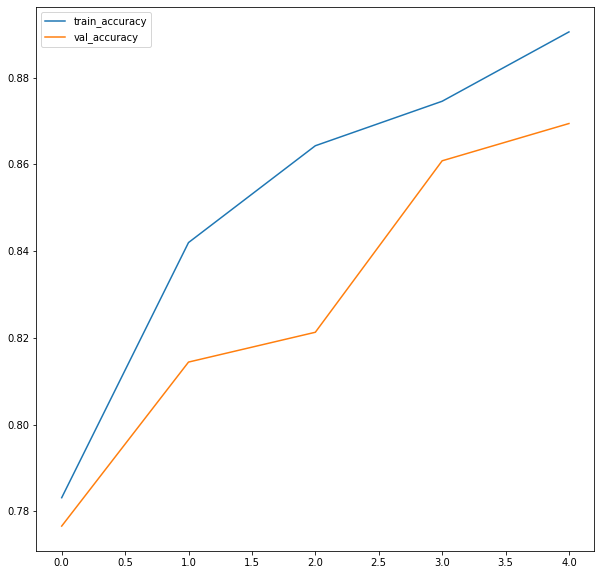

In [14]:
epochs = history.history
epochs['train_accuracy'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_accuracy','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

## evaluate and predict
Now thet we have a model we can use to predict results on the validation dataset.

accuracy: 0.8694158075601375


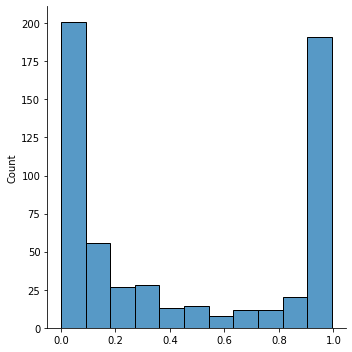

In [15]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.displot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

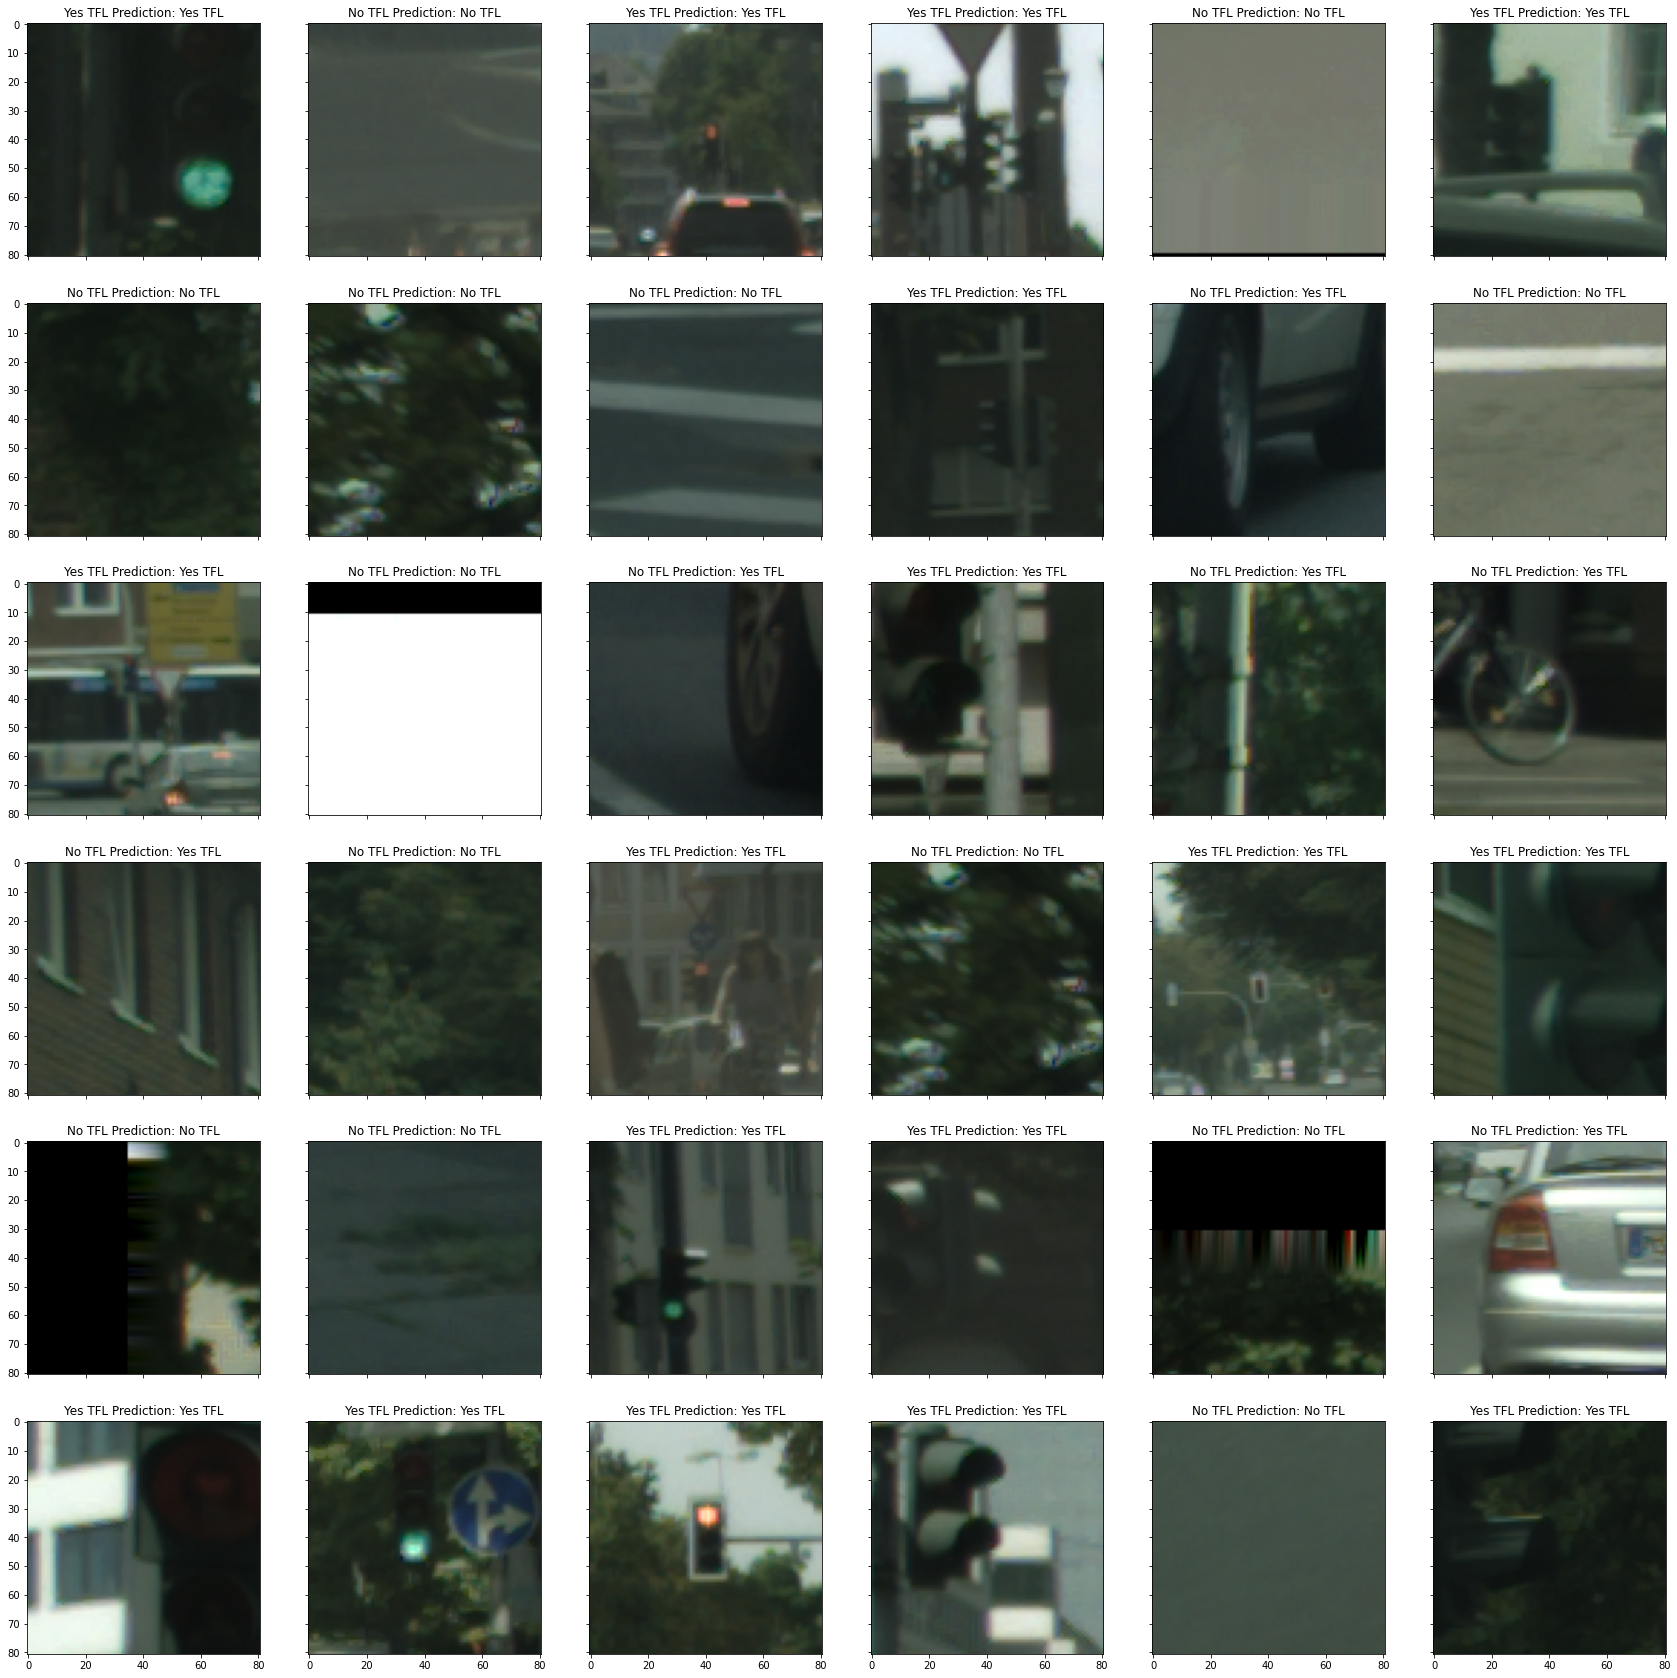

In [17]:
viz_my_data(num=(6,6),predictions=predicted_label,**val);

# saving the training model

In [18]:
m.save("model.h5")